In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_4/jj.csv')

In [4]:
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


**Test for stationarity and seasonality:**

**Series Plot**

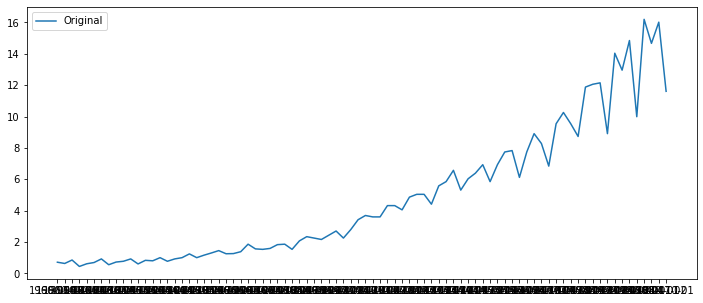

In [5]:
fig = plt.gcf()
plt.plot(df['date'],df['data'],label="Original")
plt.legend()
fig.set_size_inches(12, 5)

**ADF Test**

In [6]:
def adf_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of Dickey-Fuller Test' ,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('data')

Results of Dickey-Fuller Test 

Test Statistic                  2.742017
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


**KPSS Test**

In [7]:
def kpss_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of KPSS Test')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('data')

Results of KPSS Test
Test Statistic            0.706778
p-value                   0.012929
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**ACF PACF plot**

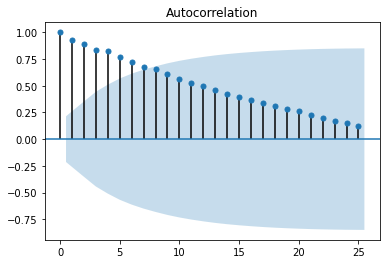

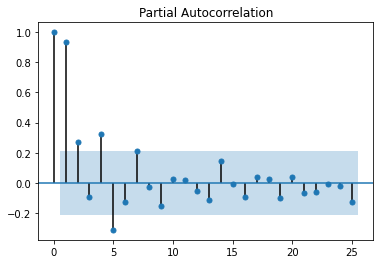

In [8]:
plot_acf(df.iloc[:,1].dropna(), lags=25)
plt.show()
plot_pacf(df.iloc[:,1].dropna(), lags=25)
plt.show()

**Observation from above tests**

From series plot, we can say that it is a non-stationary data series. Actually trend is there with seasonality. 

From ADF test: P value is greater than 0.05 so, we can say it is non-stationary series. and also the test statistic is greater than the critical value, so we fail to reject the null hypothesis. So it is non-stationary series.(trend stationary)

From KPSS Test: The test statistic is greater than the critical value so we can reject the null hypothesis. So it is non-stationary series.

Form ACF,PACF Test: More than 5% of spikes are outside bounds so series is non-stationary. and also the slow decrease in the ACF as the lags increase shows the non stationarity series. 

From series plot, we can clearly see that data is seasonal. SO yes seasonality is present. 

**Handling trend and seasonality**

In [9]:
# log differance and then 1 simple differance
df_log=np.log(df['data'])
df['log_Diff'] = df['data'].diff(periods=1)
df['simple_Diff'] = df['log_Diff'].diff(periods=1)
roll_mean=df['simple_Diff'].rolling(12).mean()  #last 12 values because 12 months in a year
roll_std=df['simple_Diff'].rolling(12).std()

In [10]:
df.head()

,date,data,log_Diff,simple_Diff
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.08,NaN
2,1960-07-02,0.85,0.22,0.30
3,1960-10-01,0.44,-0.41,-0.63
4,1961-01-01,0.61,0.17,0.58


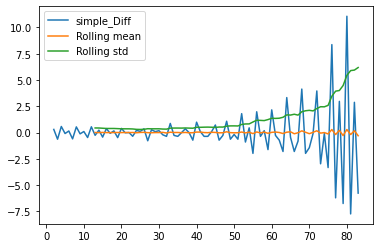

In [11]:
df['simple_Diff'].plot()
plt.plot(roll_mean, label="Rolling mean")
plt.plot(roll_std, label="Rolling std")
plt.legend()
plt.show()

In [12]:
adf_test('simple_Diff')

Results of Dickey-Fuller Test 

Test Statistic                 -3.585163
p-value                         0.006051
#Lags Used                      9.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [13]:
kpss_test('simple_Diff')

Results of KPSS Test
Test Statistic            0.189742
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


From ADF test: P value is less than 0.05 so, we can say it became stationary series. and also the test statistic is less than the critical value, so we can reject the null hypothesis. So it becomes stationary series.

From KPSS Test: The test statistic is less than the critical value so we fail to reject the null hypothesis. So it became stationary series.

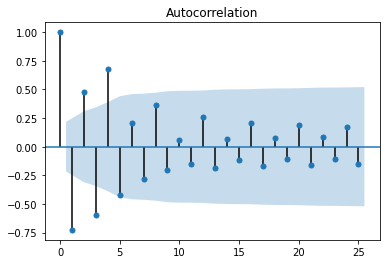

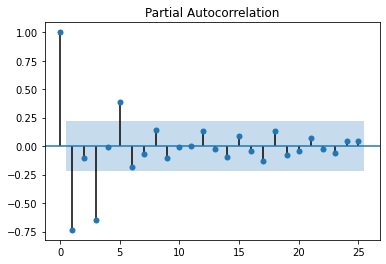

In [14]:
plot_acf(df.iloc[:,3].dropna(), lags=25)
plt.show()
plot_pacf(df.iloc[:,3].dropna(), lags=25)
plt.show()

In [15]:
new_diff = df['simple_Diff'].dropna()

In [16]:
!pip3 install pmdarima

**Auto ARIMA**

In [17]:
import pmdarima as pm
model = pm.auto_arima(df['data'].dropna(), start_p=1, start_q=1,test='adf',max_p=5, max_q=5,m=1,d=None,seasonal=False,start_P=0, D=0, 
                      trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.412, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=297.285, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=264.953, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=255.333, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=295.995, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=252.748, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=238.454, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=229.503, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=259.465, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=228.486, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=240.020, Time=0.29 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 se

**Data formulation at different intervals**

In [18]:
data = new_diff
dataset_array = [data[0::1],data[0::2],data[0::3],data[0::4]]

In [46]:
data2 = df['log_Diff'].dropna()
dataset_array2 = [data2[4::1],data2[4::2],data2[6::3],data2[7::4]]

In [20]:
data3 = df['data'].dropna()
dataset_array3 = [data3[1::1],data3[1::2],data3[1::3],data3[1::4]]

**RMSE, NSE, rsquared, time and plotting functions** 

In [21]:
def rmse(e,s):
  sum = 0
  for i in range(len(e)):
      sum += (e[i] - s[i])**2
  b = np.sqrt(sum/len(e))
  return b

In [22]:
def NSE(e,s):
  diff=e-s
  sum1=0
  sum2=0
  for i in diff:
    sum1 += i**2
  m=0
  for j in e:
    m += j
  mean = m/len(e)
  for k in e:
    sum2 += (k-(mean))**2
  NSE_val = 1-(sum1/sum2)
  return NSE_val

In [23]:
def meanfunction(col):
  sum=0
  for i in col:
    sum += i
  meanvalue = sum/len(col)
  return meanvalue

In [24]:
def rsquared(e,s):
  mean_e = meanfunction(e)
  mean_s = meanfunction(s)
  
  sum = 0
  for i,j in zip(e,s): 
    sum += (i - mean_e)*(j - mean_s)
  sum1 = 0
  for p in e: 
    sum1 += (p - mean_e)**2
  sum2 = 0
  for q in s: 
    sum2 += (q - mean_s)**2
    
  cc = sum/(np.sqrt(sum1)*np.sqrt(sum2)) 
  return (cc)**2 

In [25]:
interval_list = [1,2,3,4]

In [26]:
def time_func(dataset):
  time_array = []
  for d in dataset:
    t = range(d.shape[0])
    time_array.append(t)
  return time_array

In [27]:
def plotting_function(fc,data,time,interval):
  fig = plt.gcf()
  plt.plot(time,data,label='Original')
  plt.plot(time,fc,label='Forcasted')
  fig.set_size_inches(12,8)
  plt.legend()
  plt.ylabel('Data')
  plt.title('Prediction at interval '+str(interval))
  plt.figure()
  plt.close

**AR Model**

In [28]:
def ar_model(data):
  model=ARIMA(data,order=(1,0,0)).fit()
  prediction = model.fittedvalues
  pred = prediction.to_numpy()
  data_list = data.to_numpy() 
  rmse_val = rmse(data_list,pred)
  nse_val = NSE(data_list,pred)
  rsq_val = rsquared(data_list,pred)
  return rmse_val,nse_val,rsq_val,pred

In [29]:
RMSE1 = []
Rsquared1 = []
nse1 = []
final_forecasted_list1 = []
for dataframe in dataset_array:
  rmse_val1,nse_val1,rsq_val1,prediction1 = ar_model(dataframe)
  RMSE1.append(rmse_val1)
  nse1.append(nse_val1)
  Rsquared1.append(rsq_val1)
  final_forecasted_list1.append(prediction1)

print('RMSE for each interval respectively \n',RMSE1)
print('NSE for each interval respectively \n',nse1)
print('RSquared for each interval respectively \n',Rsquared1)

RMSE for each interval respectively 
 [1.6169451020313022, 2.358296086957389, 2.054112726656933, 0.814179129606391]
NSE for each interval respectively 
 [0.5660992905783637, 0.005180136590769324, 0.465241498039367, 0.4208105982240756]
RSquared for each interval respectively 
 [0.5662033754637066, 0.0051829136599289465, 0.46614156352126046, 0.4236714095047003]


**original and forecasted data plot from AR model**

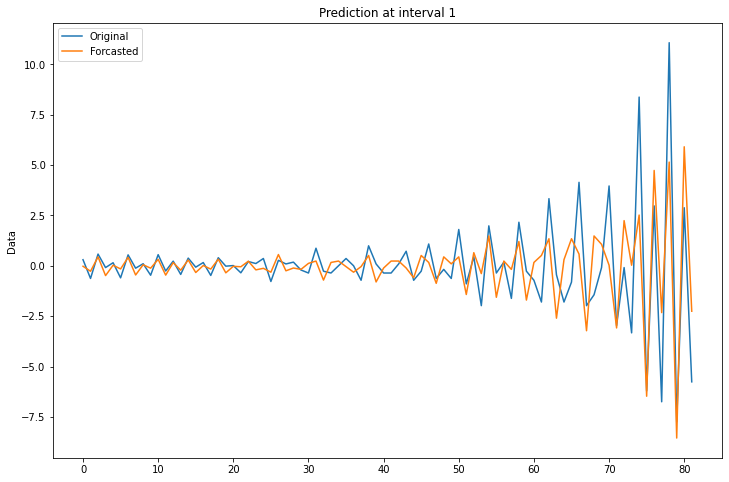

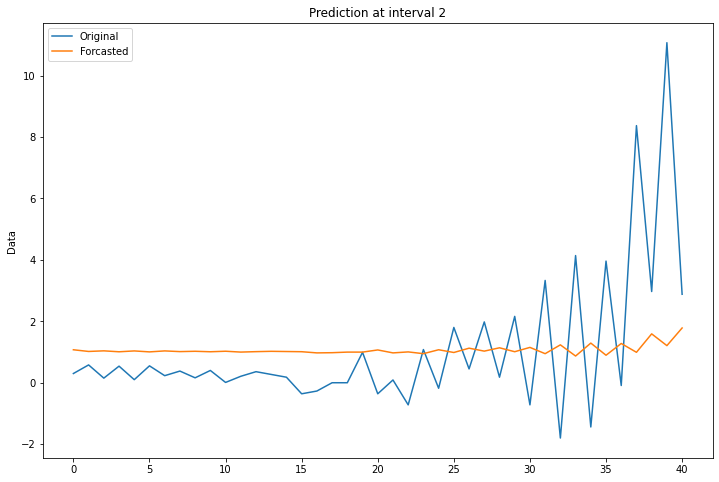

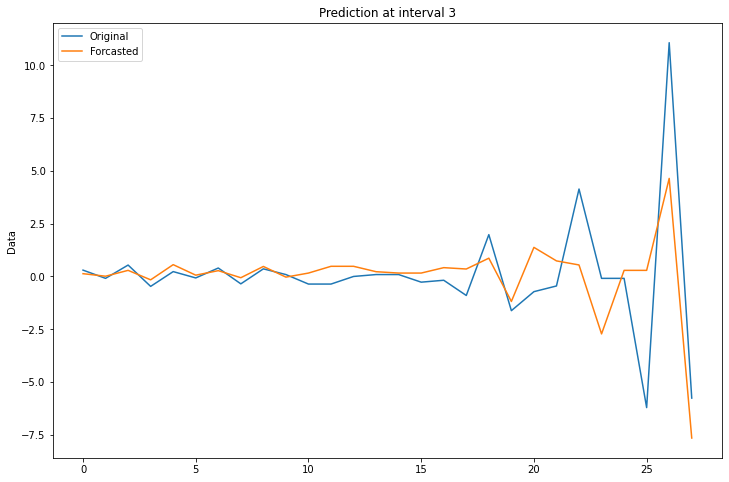

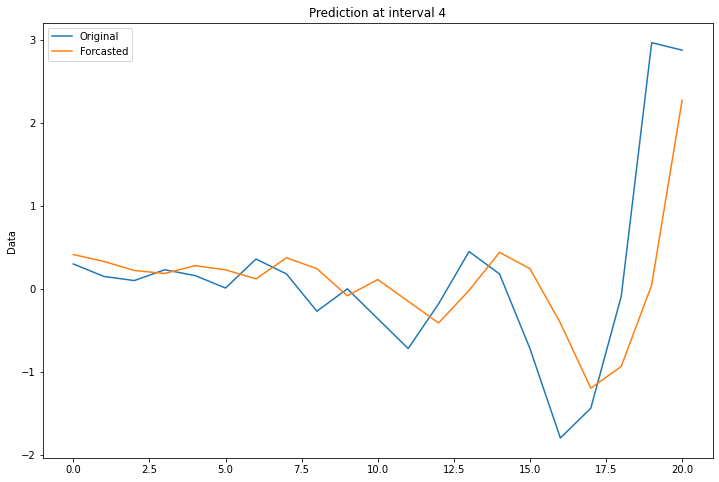

<Figure size 432x288 with 0 Axes>

In [30]:
time_list1 = time_func(dataset_array)
for fc_idx in range(4):
  plotting_function(final_forecasted_list1[fc_idx],dataset_array[fc_idx],time_list1[fc_idx],interval_list[fc_idx])

**MA Model**

In [31]:
def ma_model(data):
  model=ARIMA(data,order=(0,0,3)).fit()
  prediction = model.fittedvalues
  pred = prediction.to_numpy()
  data_list = data.to_numpy() 
  rmse_val = rmse(data_list,pred)
  nse_val = NSE(data_list,pred)
  rsq_val = rsquared(data_list,pred)
  return rmse_val,nse_val,rsq_val,pred

In [32]:
RMSE2 = []
Rsquared2 = []
nse2 = []
final_forecasted_list2 = []
for dataframe in dataset_array:
  rmse_val2,nse_val2,rsq_val2,prediction2 = ma_model(dataframe)
  RMSE2.append(rmse_val2)
  nse2.append(nse_val2)
  Rsquared2.append(rsq_val2)
  final_forecasted_list2.append(prediction2)

print('RMSE for each interval respectively \n',RMSE2)
print('NSE for each interval respectively \n',nse2)
print('RSquared for each interval respectively \n',Rsquared2)

RMSE for each interval respectively 
 [0.7938689093946888, 1.4197585512238693, 1.575251829214894, 0.617674931284053]
NSE for each interval respectively 
 [0.8954082577008615, 0.6394406404410125, 0.6855083373764608, 0.666649871941255]
RSquared for each interval respectively 
 [0.8967048817076467, 0.7863801521429036, 0.6857126080730273, 0.6669877446038149]


**original and forecasted data plot from MA model**

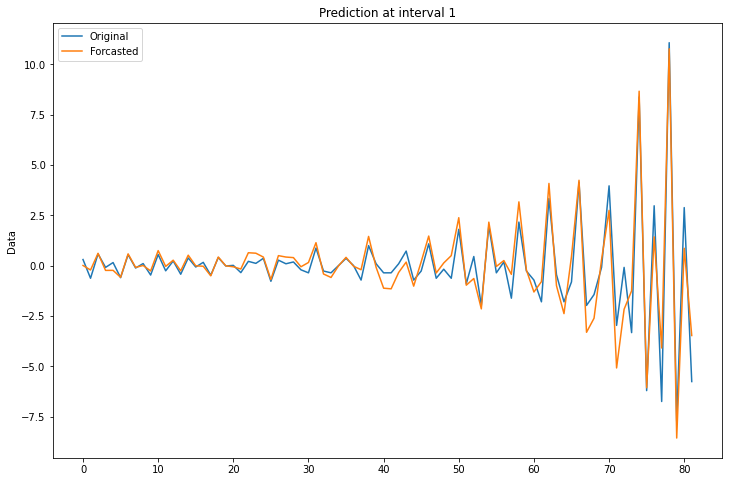

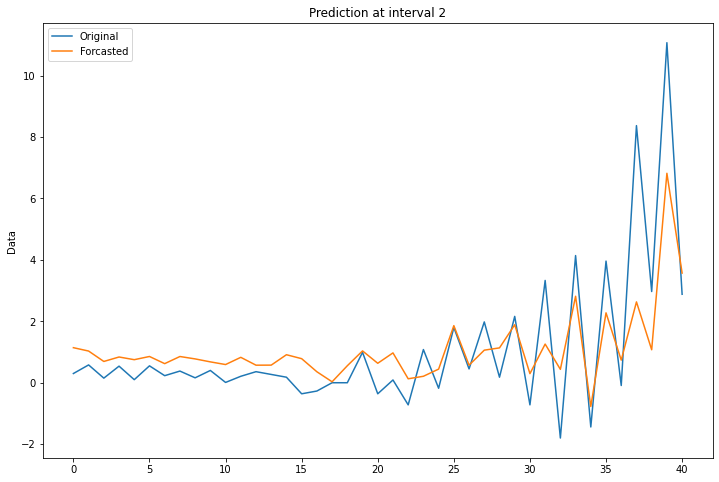

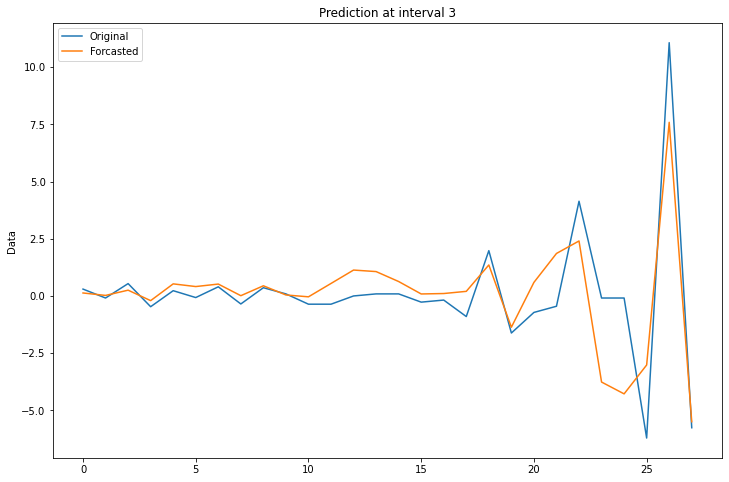

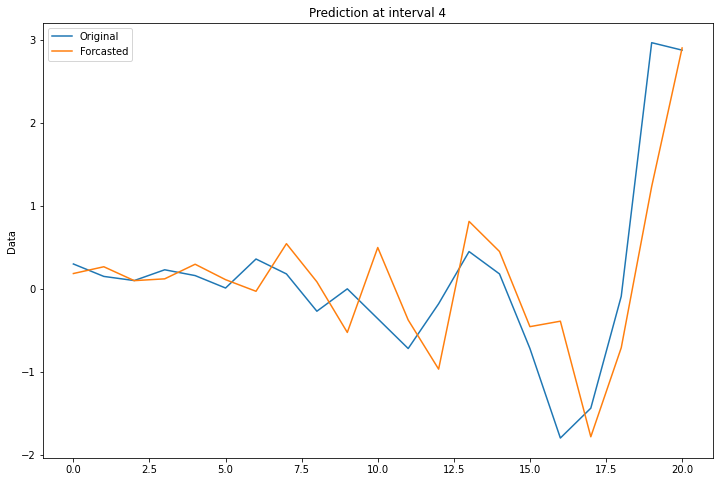

<Figure size 432x288 with 0 Axes>

In [33]:
time_list2 = time_func(dataset_array)
for fc_idx in range(4):
  plotting_function(final_forecasted_list2[fc_idx],dataset_array[fc_idx],time_list2[fc_idx],interval_list[fc_idx])

**ARMA Model**

In [34]:
def arma_model(data):
  model=ARIMA(data,order=(1,0,0)).fit()
  prediction = model.fittedvalues
  pred = prediction.to_numpy()
  data_list = data.to_numpy() 
  rmse_val = rmse(data_list,pred)
  nse_val = NSE(data_list,pred)
  rsq_val = rsquared(data_list,pred)
  return rmse_val,nse_val,rsq_val,pred

In [35]:
RMSE3 = []
Rsquared3 = []
nse3 = []
final_forecasted_list3 = []
for dataframe in dataset_array:
  rmse_val3,nse_val3,rsq_val3,prediction3 = arma_model(dataframe)
  RMSE3.append(rmse_val3)
  nse3.append(nse_val3)
  Rsquared3.append(rsq_val3)
  final_forecasted_list3.append(prediction3)

print('RMSE for each interval respectively \n',RMSE3)
print('NSE for each interval respectively \n',nse3)
print('RSquared for each interval respectively \n',Rsquared3)

RMSE for each interval respectively 
 [1.6169451020313022, 2.358296086957389, 2.054112726656933, 0.814179129606391]
NSE for each interval respectively 
 [0.5660992905783637, 0.005180136590769324, 0.465241498039367, 0.4208105982240756]
RSquared for each interval respectively 
 [0.5662033754637066, 0.0051829136599289465, 0.46614156352126046, 0.4236714095047003]


**original and forecasted data plot from ARMA model**

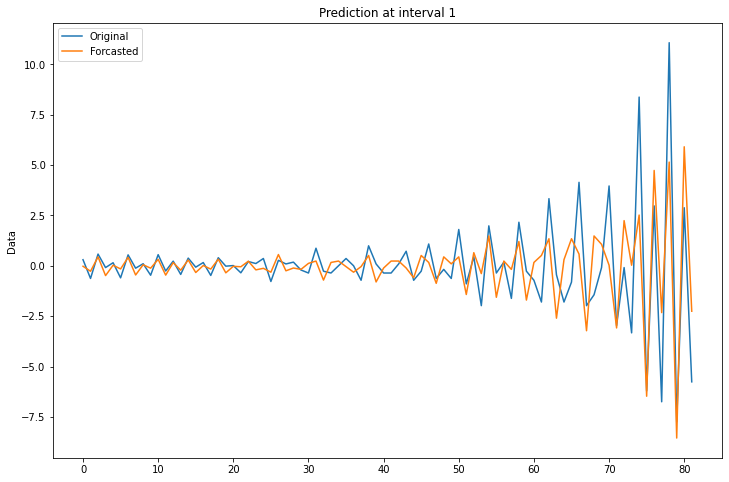

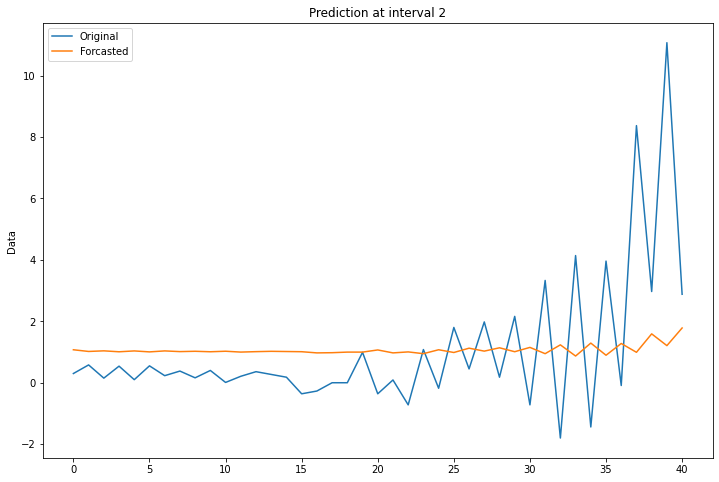

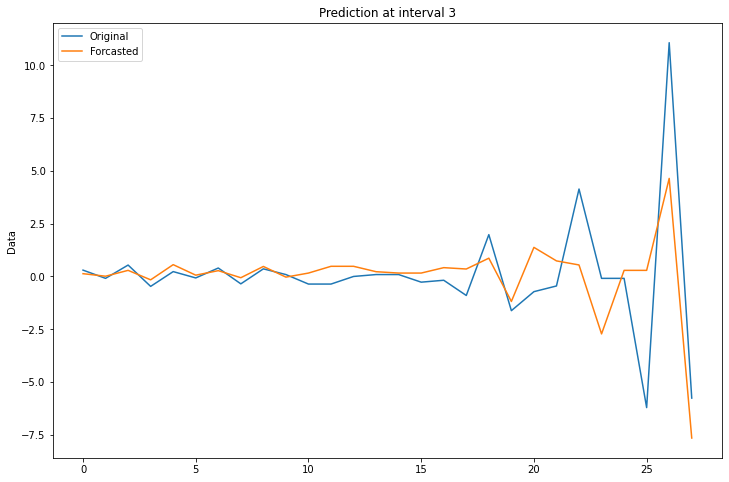

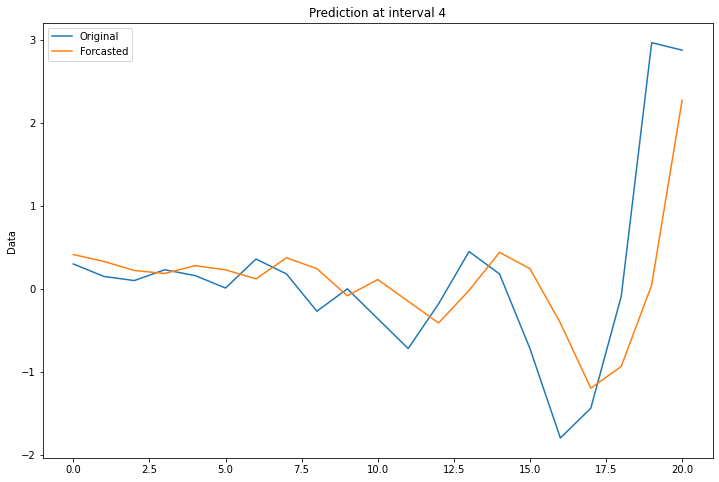

<Figure size 432x288 with 0 Axes>

In [36]:
time_list3 = time_func(dataset_array)
for fc_idx in range(4):
  plotting_function(final_forecasted_list3[fc_idx],dataset_array[fc_idx],time_list3[fc_idx],interval_list[fc_idx])

**ARIMA Model**

In [37]:
def arima_model(data):
  model=ARIMA(data,order=(1,1,0)).fit()
  prediction = model.fittedvalues
  pred = prediction.to_numpy()
  data_list = data.to_numpy() 
  data_list = data_list[1:]
  rmse_val = rmse(data_list,pred)
  nse_val = NSE(data_list,pred)
  rsq_val = rsquared(data_list,pred)
  return rmse_val,nse_val,rsq_val,pred,data_list

In [38]:
RMSE4 = []
Rsquared4 = []
nse4 = []
final_forecasted_list4 = []
dlist4 = []
for dataframe in dataset_array2:
  rmse_val4,nse_val4,rsq_val4,prediction4,data_list4 = arima_model(dataframe)
  RMSE4.append(rmse_val4)
  nse4.append(nse_val4)
  Rsquared4.append(rsq_val4)
  final_forecasted_list4.append(prediction4)
  dlist4.append(data_list4)

print('RMSE for each interval respectively \n',RMSE4)
print('NSE for each interval respectively \n',nse4)
print('RSquared for each interval respectively \n',Rsquared4)

RMSE for each interval respectively 
 [1.758889358379287, 1.311572929833854, 1.9407422968473014, 0.5750557960790321]
NSE for each interval respectively 
 [-0.47169834028904356, -0.1011971719509055, -0.6010548821006982, 0.09467698443480532]
RSquared for each interval respectively 
 [0.2134459667483262, 0.3056416320000893, 0.11150397296134815, 0.6094912880905858]


**original and forecasted data plot from ARIMA model**

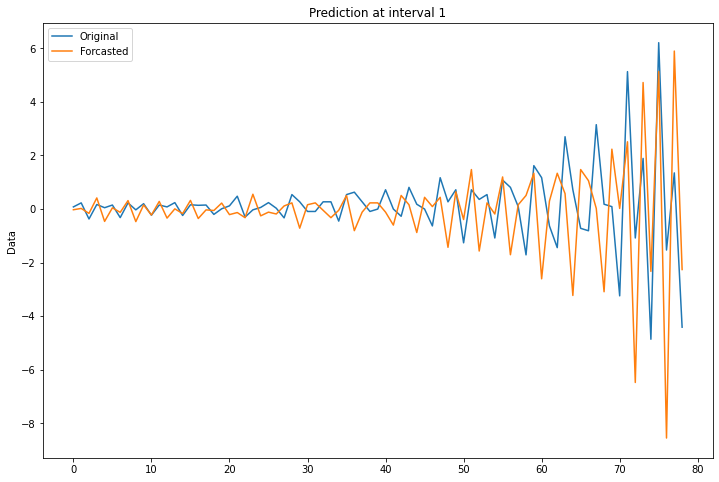

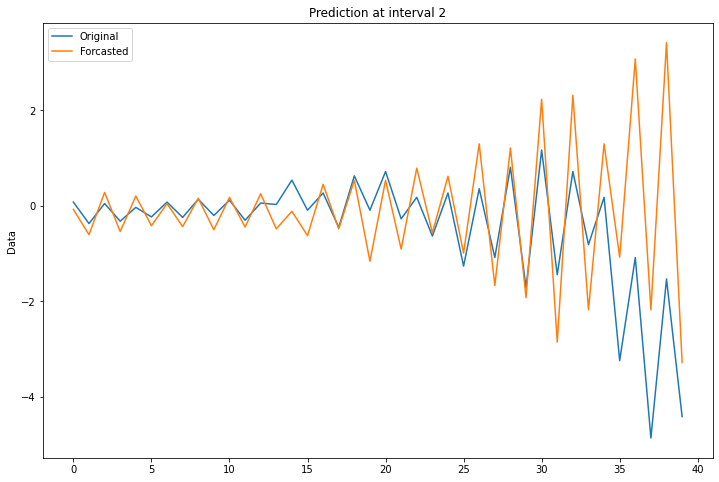

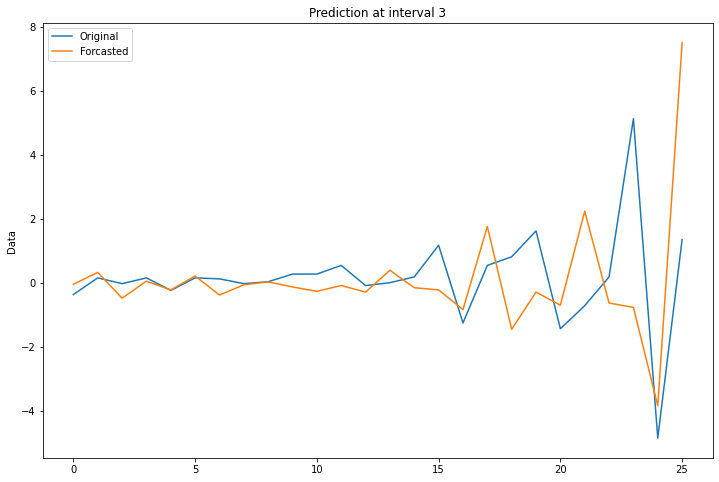

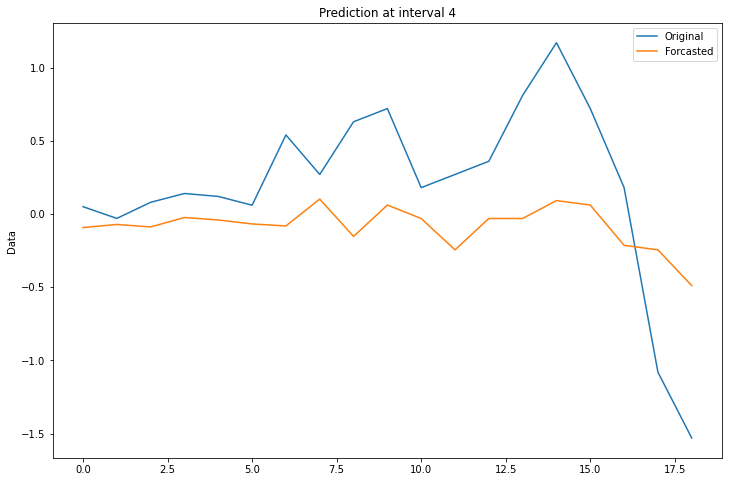

<Figure size 432x288 with 0 Axes>

In [47]:
time_list4 = time_func(dataset_array2)
for fc_idx in range(4):
  plotting_function(final_forecasted_list4[fc_idx],dlist4[fc_idx],time_list4[fc_idx],interval_list[fc_idx])

**SARIMA Model**

In [48]:
def sarima_model(data):
  model=SARIMAX(data, seasonal_order=(1,1,3,12), order=(1,1,3)).fit()  
  prediction = model.fittedvalues
  pred = prediction.to_numpy()
  data_list = data.to_numpy() 
  rmse_val = rmse(data_list,pred)
  nse_val = NSE(data_list,pred)
  rsq_val = rsquared(data_list,pred)
  return rmse_val,nse_val,rsq_val,pred,data_list

In [49]:
RMSE5 = []
Rsquared5 = []
nse5 = []
final_forecasted_list5 = []
dlist5 = []
for dataframe in dataset_array3:
  rmse_val5,nse_val5,rsq_val5,prediction5,data_list5 = sarima_model(dataframe)
  RMSE5.append(rmse_val5)
  nse5.append(nse_val5)
  Rsquared5.append(rsq_val5)
  final_forecasted_list5.append(prediction5)
  dlist5.append(data_list5)

print('RMSE for each interval respectively \n',RMSE5)
print('NSE for each interval respectively \n',nse5)
print('RSquared for each interval respectively \n',Rsquared5)

RMSE for each interval respectively 
 [0.541431743150613, 0.42416034257306107, 1.2538878534286675, 0.4878594951649522]
NSE for each interval respectively 
 [0.9840438102302382, 0.9883621027564241, 0.9142650484648525, 0.9876767302526347]
RSquared for each interval respectively 
 [0.9848377448590007, 0.9903432644888283, 0.9255000942414019, 0.9933916517501846]


**original and forecasted data plot from SARIMA model**

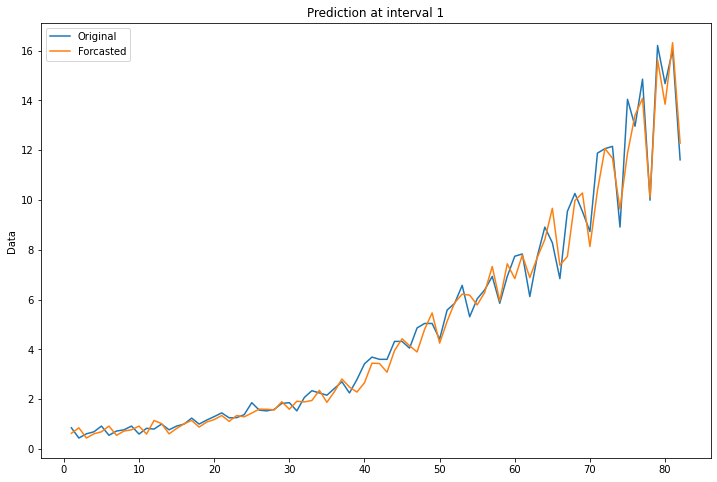

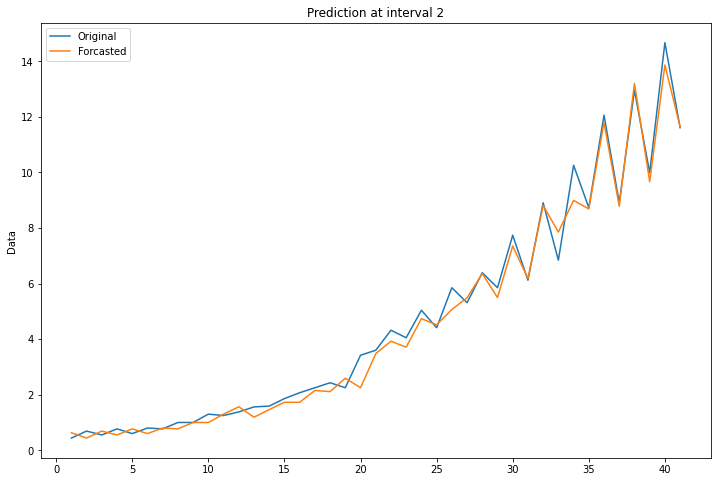

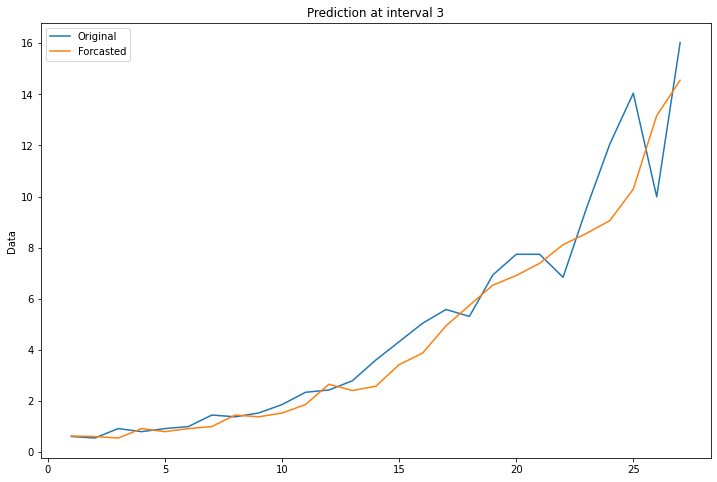

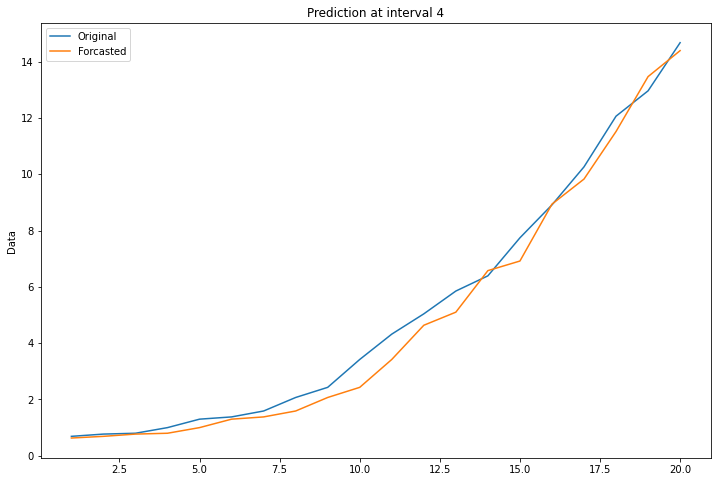

<Figure size 432x288 with 0 Axes>

In [50]:
time_list5 = time_func(dataset_array3)
for fc_idx in range(4):
  plotting_function(final_forecasted_list5[fc_idx][1:],dlist5[fc_idx][1:],time_list5[fc_idx][1:],interval_list[fc_idx])

**Inference**

From plots and RMSE, We can say that predictions from SARIMA model is better compare to other models for above order. SARIMA performs far better than rest models as data is seasonal.   